# Let's Build a Quant Trading Strategy - Part 2

In [1]:
# signal = model(x)
# orders = strategy(signal)
# execute(orders)

In [2]:
# This file is about using our model to create a strategy based on our model's predictions

In [3]:
# The model uses lag 1, lag 2.

### Strategy Types

In [4]:
# 1 Maker strategies => they are providing liquidity => adding liquidity to a market and aim to be compensated for it
# 2 Taker strategies => they taking away liquidity => market orders that consume liquidity => what we are going to focus on

In [5]:
# Key Questions for our taking strategy

# 1. Entry/Exit
# 2. Trade Sizing
# 3. Leverage

In [6]:
## the key goal is we want to create a strategy that maximises profits from the model's statistical edge

### Import Libraries

In [7]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Binance market data utilities


###  Load Model

In [8]:
import models
model = models.LinearModel(2)
# security alert 
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

LinearModel(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

### Model Parameters

In [9]:
research.print_model_params(model)

linear.weight:
[[-0.15595101 -0.10587536]]
linear.bias:
[-0.00084034]


## Strategy Development!

### Load Time Series

In [10]:
sym = 'ADAUSDT'
time_interval = '12h'
download_window = 7 * 4 * 6 * 2

binance.download_trades(sym, download_window)

In [11]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading ADAUSDT: 100%|██████████████████████| 342/342 [00:09<00:00, 36.26file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0321,0.9822,0.9978
2024-11-28 12:00:00,0.9978,1.05,0.9708,1.0328
2024-11-29 00:00:00,1.0328,1.0883,1.0283,1.065
2024-11-29 12:00:00,1.0649,1.1008,1.0381,1.0762
2024-11-30 00:00:00,1.0763,1.1516,1.0509,1.0953
…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526


### Add Target and Features

In [12]:
forecast_horizon = 1
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=3)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0321,0.9822,0.9978,null,null,null,null
2024-11-28 12:00:00,0.9978,1.05,0.9708,1.0328,0.034476,null,null,null
2024-11-29 00:00:00,1.0328,1.0883,1.0283,1.065,0.030701,0.034476,null,null
2024-11-29 12:00:00,1.0649,1.1008,1.0381,1.0762,0.010462,0.030701,0.034476,null
2024-11-30 00:00:00,1.0763,1.1516,1.0509,1.0953,0.017592,0.010462,0.030701,0.034476
…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446


### Time Split 

In [13]:
test_size = 0.25
_, trades = research.timeseries_split(ts, test_size)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103
…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446


## Strategy Decision # 1: Entry / Exit Signal

In [14]:
# q1: when do we get in? entry signal
# q2: when do we get out? exit signal

In [15]:
# 1. Time Based 
# 2. Predicate Based 

In [16]:
# predicate example => we only want to trade if our y_hat is above or below a certain threshold

In [17]:
# time based => each row represents a roundtrip trade. trade to open position at start of interval, trade to close the position at end of interval. each row = 2 trades. 

In [18]:
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103
…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446


### Add Model's Predictions

In [19]:
target = 'close_log_return'
features = [f'{target}_lag_1',f'{target}_lag_2']
trades = research.add_model_predictions(trades, model, features)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572,-0.000168
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826,0.004183
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137,0.001102
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913,-0.013993
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103,-0.016491
…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.001239
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,-0.000182
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.008993


### Add Directional Signal

In [20]:
trades = trades.with_columns(pl.col('y_hat').sign().alias('dir_signal'))
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572,-0.000168,-1.0
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826,0.004183,1.0
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137,0.001102,1.0
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913,-0.013993,-1.0
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103,-0.016491,-1.0
…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.001239,-1.0
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,-0.000182,-1.0
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.008993,1.0


### Calculate Trade Log Return

In [21]:
trades = trades.with_columns((pl.col('close_log_return')*pl.col('dir_signal')).alias('trade_log_return'))
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572,-0.000168,-1.0,0.022913
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826,0.004183,1.0,0.003103
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137,0.001102,1.0,0.082235
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913,-0.013993,-1.0,-0.044529
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103,-0.016491,-1.0,-0.028032
…,…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.001239,-1.0,0.005881
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,-0.000182,-1.0,0.059059
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.008993,1.0,-0.040257


### Calculate Cumulative Trade Log Return

In [22]:
trades = trades.with_columns(pl.col('trade_log_return').cum_sum().alias('cum_trade_log_return'))
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572,-0.000168,-1.0,0.022913,0.022913
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826,0.004183,1.0,0.003103,0.026016
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137,0.001102,1.0,0.082235,0.10825
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913,-0.013993,-1.0,-0.044529,0.063721
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103,-0.016491,-1.0,-0.028032,0.035689
…,…,…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.001239,-1.0,0.005881,1.229523
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,-0.000182,-1.0,0.059059,1.288582
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.008993,1.0,-0.040257,1.248325


### Display Equity Curve (Log Space)

In [23]:
research.plot_column(trades, 'cum_trade_log_return')

alt.Chart(...)

## Key Strategy Decision #2: Trade Sizing

In [24]:
# 1. Constant Trade Size
# 2. Compounding Trade Size

In [25]:
capital = 100
ratio = 1.0 # you could experiment with different ratios like kelly criterion
trade_value = ratio * capital

# entry trade value and exit trade value
trades = trades.with_columns(
    pl.lit(trade_value).alias('entry_trade_value'),
    (trade_value * pl.col('trade_log_return').exp()).alias('exit_trade_value'),
    (trade_value / pl.col('open')).alias('trade_qty'),
).with_columns(
    (pl.col('trade_qty') * pl.col('dir_signal')).alias('signed_trade_qty'),
)

trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty')

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty
datetime[μs],f64,f64,f64,f32,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.7723,0.022913,-0.000168,100.0,102.317752,-126.55024
2025-08-12 00:00:00,0.7723,0.7747,0.003103,0.004183,100.0,100.31076,129.483361
2025-08-12 12:00:00,0.7746,0.8411,0.082235,0.001102,100.0,108.57106,129.09889
2025-08-13 00:00:00,0.841,0.8794,-0.044529,-0.013993,100.0,95.644758,-118.906064
2025-08-13 12:00:00,0.8794,0.9044,-0.028032,-0.016491,100.0,97.235736,-113.713896
…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6103,0.005881,-0.001239,100.0,100.589874,-162.919518
2025-11-03 00:00:00,0.6103,0.5753,0.059059,-0.000182,100.0,106.083782,-163.853842
2025-11-03 12:00:00,0.5754,0.5526,-0.040257,0.008993,100.0,96.054233,173.792145


### Add Trade Gross PnL

In [26]:
trades = trades.with_columns((pl.col('exit_trade_value') - pl.col('entry_trade_value')).alias('trade_gross_pnl'))
trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty', )

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty
datetime[μs],f64,f64,f64,f32,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.7723,0.022913,-0.000168,100.0,102.317752,-126.55024
2025-08-12 00:00:00,0.7723,0.7747,0.003103,0.004183,100.0,100.31076,129.483361
2025-08-12 12:00:00,0.7746,0.8411,0.082235,0.001102,100.0,108.57106,129.09889
2025-08-13 00:00:00,0.841,0.8794,-0.044529,-0.013993,100.0,95.644758,-118.906064
2025-08-13 12:00:00,0.8794,0.9044,-0.028032,-0.016491,100.0,97.235736,-113.713896
…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6103,0.005881,-0.001239,100.0,100.589874,-162.919518
2025-11-03 00:00:00,0.6103,0.5753,0.059059,-0.000182,100.0,106.083782,-163.853842
2025-11-03 12:00:00,0.5754,0.5526,-0.040257,0.008993,100.0,96.054233,173.792145


### Add Transaction Fees

In [27]:
taker_fee = binance.TAKER_FEE
maker_fee = binance.MAKER_FEE

trades = trades.with_columns(
    (pl.col('entry_trade_value') * taker_fee + pl.col('exit_trade_value') * taker_fee).alias('taker_fee'),
    (pl.col('entry_trade_value') * maker_fee + pl.col('exit_trade_value') * maker_fee).alias('maker_fee')
)

trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty', 'trade_gross_pnl','maker_fee','taker_fee')

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty,trade_gross_pnl,maker_fee,taker_fee
datetime[μs],f64,f64,f64,f32,f64,f64,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.7723,0.022913,-0.000168,100.0,102.317752,-126.55024,2.317752,0.091043,0.091043
2025-08-12 00:00:00,0.7723,0.7747,0.003103,0.004183,100.0,100.31076,129.483361,0.31076,0.09014,0.09014
2025-08-12 12:00:00,0.7746,0.8411,0.082235,0.001102,100.0,108.57106,129.09889,8.57106,0.093857,0.093857
2025-08-13 00:00:00,0.841,0.8794,-0.044529,-0.013993,100.0,95.644758,-118.906064,-4.355242,0.08804,0.08804
2025-08-13 12:00:00,0.8794,0.9044,-0.028032,-0.016491,100.0,97.235736,-113.713896,-2.764264,0.088756,0.088756
…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6103,0.005881,-0.001239,100.0,100.589874,-162.919518,0.589874,0.090265,0.090265
2025-11-03 00:00:00,0.6103,0.5753,0.059059,-0.000182,100.0,106.083782,-163.853842,6.083782,0.092738,0.092738
2025-11-03 12:00:00,0.5754,0.5526,-0.040257,0.008993,100.0,96.054233,173.792145,-3.945767,0.088224,0.088224


### Calculate Trade Net PnL

In [28]:
trades = trades.with_columns(
    (pl.col('trade_gross_pnl')-pl.col('taker_fee')).alias('trade_net_taker_pnl'),
    (pl.col('trade_gross_pnl')-pl.col('maker_fee')).alias('trade_net_maker_pnl'),
)

trades.select('datetime','open','close', 'trade_log_return','y_hat','entry_trade_value','exit_trade_value', 'signed_trade_qty', 'trade_gross_pnl','trade_net_taker_pnl','trade_net_maker_pnl')

datetime,open,close,trade_log_return,y_hat,entry_trade_value,exit_trade_value,signed_trade_qty,trade_gross_pnl,trade_net_taker_pnl,trade_net_maker_pnl
datetime[μs],f64,f64,f64,f32,f64,f64,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.7723,0.022913,-0.000168,100.0,102.317752,-126.55024,2.317752,2.226709,2.226709
2025-08-12 00:00:00,0.7723,0.7747,0.003103,0.004183,100.0,100.31076,129.483361,0.31076,0.22062,0.22062
2025-08-12 12:00:00,0.7746,0.8411,0.082235,0.001102,100.0,108.57106,129.09889,8.57106,8.477203,8.477203
2025-08-13 00:00:00,0.841,0.8794,-0.044529,-0.013993,100.0,95.644758,-118.906064,-4.355242,-4.443282,-4.443282
2025-08-13 12:00:00,0.8794,0.9044,-0.028032,-0.016491,100.0,97.235736,-113.713896,-2.764264,-2.85302,-2.85302
…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6103,0.005881,-0.001239,100.0,100.589874,-162.919518,0.589874,0.499608,0.499608
2025-11-03 00:00:00,0.6103,0.5753,0.059059,-0.000182,100.0,106.083782,-163.853842,6.083782,5.991045,5.991045
2025-11-03 12:00:00,0.5754,0.5526,-0.040257,0.008993,100.0,96.054233,173.792145,-3.945767,-4.033992,-4.033992


### Display Equity Curves for Constant Sizing

In [29]:
def equity_curve(capital, col_name, suffix):
    return (capital + (pl.col(col_name).cum_sum())).alias(f'equity_curve_{suffix}')

trades = trades.with_columns(
    equity_curve(capital, 'trade_net_taker_pnl', 'taker'),
    equity_curve(capital, 'trade_net_maker_pnl', 'maker'),
    equity_curve(capital, 'trade_gross_pnl', 'gross'),
)
trades.select('datetime','equity_curve_gross','equity_curve_taker','equity_curve_maker')

datetime,equity_curve_gross,equity_curve_taker,equity_curve_maker
datetime[μs],f64,f64,f64
2025-08-11 12:00:00,102.317752,102.226709,102.226709
2025-08-12 00:00:00,102.628512,102.447329,102.447329
2025-08-12 12:00:00,111.199572,110.924532,110.924532
2025-08-13 00:00:00,106.84433,106.48125,106.48125
2025-08-13 12:00:00,104.080066,103.62823,103.62823
…,…,…,…
2025-11-02 12:00:00,233.108647,218.018748,218.018748
2025-11-03 00:00:00,239.192429,224.009792,224.009792
2025-11-03 12:00:00,235.246662,219.975801,219.975801


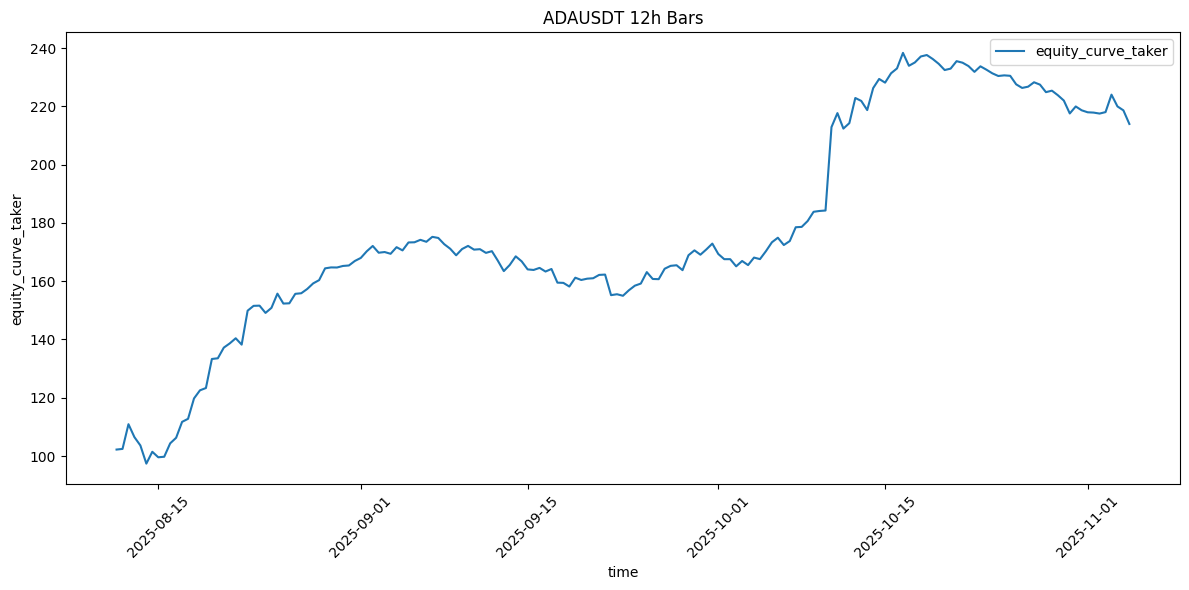

In [30]:
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

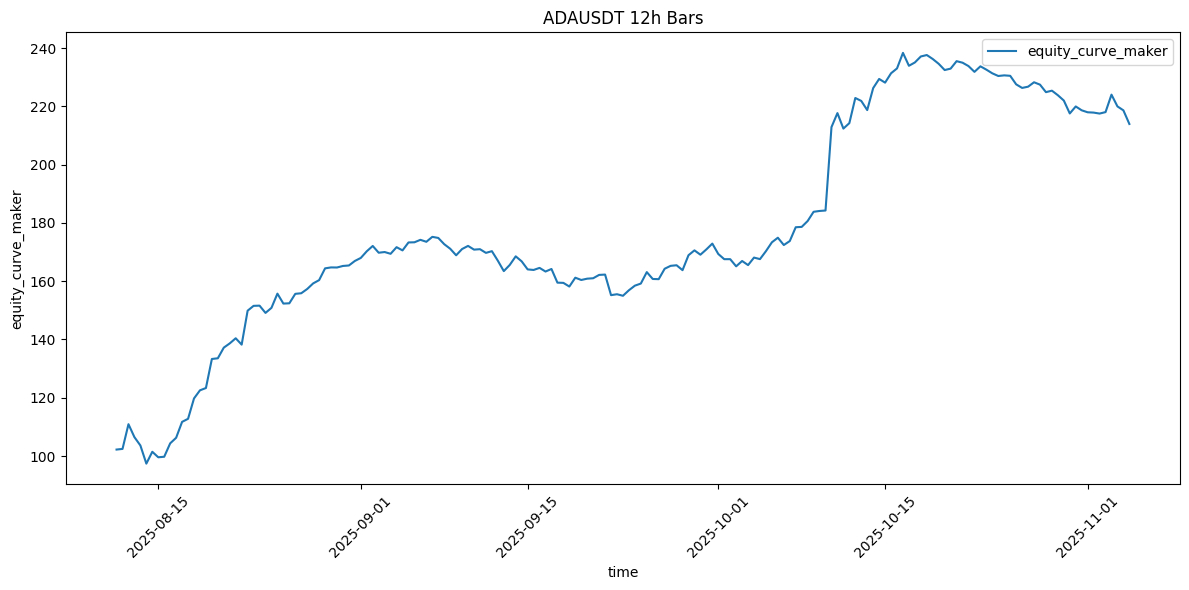

In [31]:
research.plot_static_timeseries(trades, sym, 'equity_curve_maker', time_interval)

### Calculate Total Net Return using Constant Sizing

In [32]:
constant_sizing_net_return = trades['equity_curve_taker'][-1] / capital - 1
constant_sizing_net_return

1.1394958201024843

## experiment with compounding trade sizes

In [33]:
# 2 => 102 (100 + 2)
# 1 => 103 (100 + 2 + 1)
# -1 => 102 (100 + 2 + 1 - 1)

In [34]:
log_return_1 = 0.005439
pnl1 = capital * np.exp(log_return_1)
pnl1

np.float64(100.54538182137402)

In [35]:
log_return_2 = 0.008597
pnl2 = pnl1 * np.exp(log_return_2)
pnl2

np.float64(101.41349671401576)

In [36]:
log_return_3 = 0.001385
pnl3 = pnl2 * np.exp(log_return_3)
pnl3

np.float64(101.55405171883751)

In [37]:
((capital * np.exp(0.005349)) * np.exp(0.008597)) * np.exp(0.001385)

np.float64(101.5449122654644)

### Time Addivitivity

In [38]:
capital * np.exp(log_return_1 + log_return_2 + log_return_3)

np.float64(101.55405171883751)

### Add Compounding Trade Sizes

In [39]:
trades = trades.with_columns(
    ((pl.col('cum_trade_log_return').exp()) * capital).shift().fill_null(capital).alias('entry_trade_value'),
    ((pl.col('cum_trade_log_return').exp()) * capital).alias('exit_trade_value'),
).with_columns(
    (pl.col('entry_trade_value') / pl.col('open') * pl.col('dir_signal')).alias('signed_trade_qty'),
    (pl.col('exit_trade_value')-pl.col('entry_trade_value')).alias('trade_gross_pnl'),
)
trades.select('datetime','open','close','trade_log_return','entry_trade_value','exit_trade_value','signed_trade_qty','trade_gross_pnl')

datetime,open,close,trade_log_return,entry_trade_value,exit_trade_value,signed_trade_qty,trade_gross_pnl
datetime[μs],f64,f64,f64,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.7723,0.022913,100.0,102.317752,-126.55024,2.317752
2025-08-12 00:00:00,0.7723,0.7747,0.003103,102.317752,102.635715,132.484465,0.317963
2025-08-12 12:00:00,0.7746,0.8411,0.082235,102.635715,111.432683,132.501568,8.796968
2025-08-13 00:00:00,0.841,0.8794,-0.044529,111.432683,106.57952,-132.500218,-4.853163
2025-08-13 12:00:00,0.8794,0.9044,-0.028032,106.57952,103.633381,-121.195724,-2.946139
…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6103,0.005881,339.954515,341.959818,-553.852257,2.005303
2025-11-03 00:00:00,0.6103,0.5753,0.059059,341.959818,362.763909,-560.314302,20.804091
2025-11-03 12:00:00,0.5754,0.5526,-0.040257,362.763909,348.450089,630.455178,-14.31382


### Add Transaction Fees

In [40]:
trades = research.add_tx_fees(trades, binance.MAKER_FEE, binance.TAKER_FEE)
trades.select('datetime','entry_trade_value','exit_trade_value','tx_fee_maker','tx_fee_taker')

datetime,entry_trade_value,exit_trade_value,tx_fee_maker,tx_fee_taker
datetime[μs],f64,f64,f64,f64
2025-08-11 12:00:00,100.0,102.317752,0.091043,0.091043
2025-08-12 00:00:00,102.317752,102.635715,0.092229,0.092229
2025-08-12 12:00:00,102.635715,111.432683,0.096331,0.096331
2025-08-13 00:00:00,111.432683,106.57952,0.098105,0.098105
2025-08-13 12:00:00,106.57952,103.633381,0.094596,0.094596
…,…,…,…,…
2025-11-02 12:00:00,339.954515,341.959818,0.306861,0.306861
2025-11-03 00:00:00,341.959818,362.763909,0.317126,0.317126
2025-11-03 12:00:00,362.763909,348.450089,0.320046,0.320046


### Add Trade Net PnL

In [41]:
trades = trades.with_columns(
    (pl.col('trade_gross_pnl') - pl.col('tx_fee_taker')).alias('trade_net_taker_pnl')
)
trades.select('datetime','open','close','close_log_return','y_hat','entry_trade_value','exit_trade_value','trade_gross_pnl','trade_net_taker_pnl')

datetime,open,close,close_log_return,y_hat,entry_trade_value,exit_trade_value,trade_gross_pnl,trade_net_taker_pnl
datetime[μs],f64,f64,f64,f32,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.7723,-0.022913,-0.000168,100.0,102.317752,2.317752,2.226709
2025-08-12 00:00:00,0.7723,0.7747,0.003103,0.004183,102.317752,102.635715,0.317963,0.225734
2025-08-12 12:00:00,0.7746,0.8411,0.082235,0.001102,102.635715,111.432683,8.796968,8.700638
2025-08-13 00:00:00,0.841,0.8794,0.044529,-0.013993,111.432683,106.57952,-4.853163,-4.951269
2025-08-13 12:00:00,0.8794,0.9044,0.028032,-0.016491,106.57952,103.633381,-2.946139,-3.040735
…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6103,-0.005881,-0.001239,339.954515,341.959818,2.005303,1.698441
2025-11-03 00:00:00,0.6103,0.5753,-0.059059,-0.000182,341.959818,362.763909,20.804091,20.486965
2025-11-03 12:00:00,0.5754,0.5526,-0.040257,0.008993,362.763909,348.450089,-14.31382,-14.633866


### Display Equity Curve (Compounding)

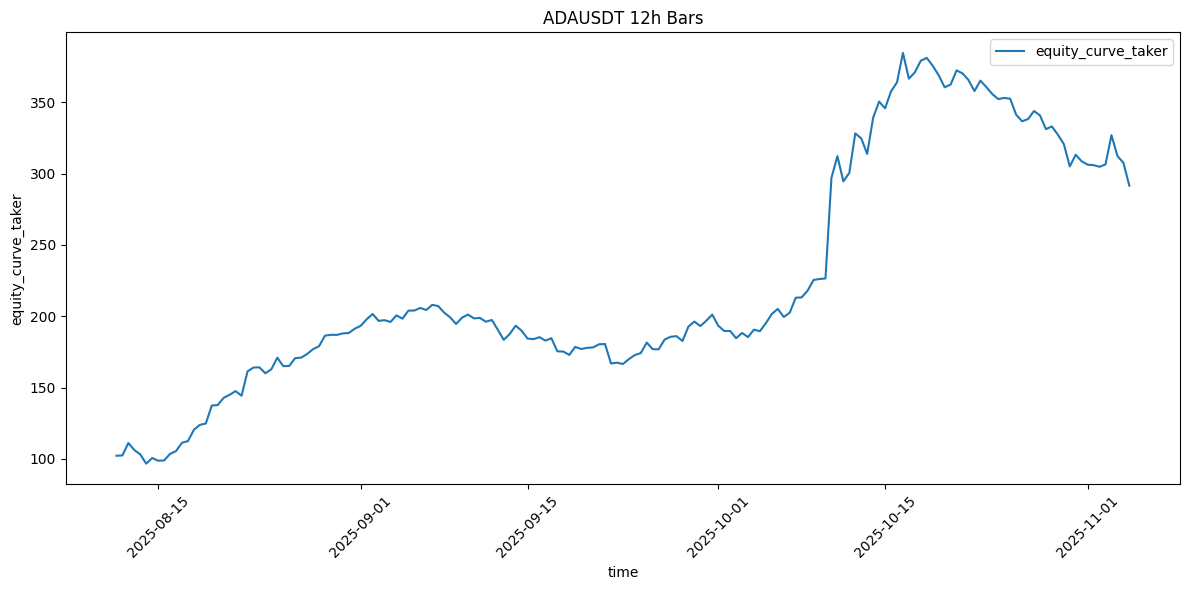

In [42]:
trades = research.add_equity_curve(trades, capital, 'trade_net_taker_pnl', 'taker')
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

### Calculate Total Net Return for Compounding Trade Sizing

In [43]:
compound_total_net_return = trades['equity_curve_taker'][-1] / capital - 1
compound_total_net_return

1.9156681138752365

In [44]:
constant_sizing_net_return

1.1394958201024843

In [45]:
np.round(compound_total_net_return - constant_sizing_net_return, 2)

np.float64(0.78)

## Key Strategy Decision #3: Leverage

In [46]:
# leverage is borrowing money to increase our profits

In [47]:
leverage = 4
leverage * capital

400

In [48]:
# in theory, we are multiplying our trade size to increase our returns

In [49]:
# we are not multiplying our trade returns

In [50]:
# just remember, it amplifies BOTH your profit and losses so it's important to have a postive expected value

In [51]:
# leverage only works when you have a high Sharpe model. The more risk you reduce, the more you reduce drawdowns and more leverage you can use

In [52]:
# key decision 3: should we use leverage? if so, how much? What's the sweet spot?

In [53]:
# It's not a golden utopia to multiplying profits, because it can easily wipe you out 

In [54]:
trades = research.add_compounding_trades(trades, capital, leverage, maker_fee, taker_fee)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,entry_trade_value,exit_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,taker_fee,maker_fee,trade_net_taker_pnl,trade_net_maker_pnl,equity_curve_taker,equity_curve_maker,equity_curve_gross,tx_fee_maker,tx_fee_taker
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572,-0.000168,-1.0,0.022913,0.022913,400.0,409.271009,126.55024,-506.200962,9.271009,0.091043,0.091043,8.906837,8.906837,108.906837,108.906837,109.271009,0.364172,0.364172
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826,0.004183,1.0,0.003103,0.026016,409.271009,410.54286,129.483361,529.937859,1.271851,0.09014,0.09014,0.902935,0.902935,109.809771,109.809771,110.54286,0.368916,0.368916
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137,0.001102,1.0,0.082235,0.10825,410.54286,445.730733,129.09889,530.006274,35.187874,0.093857,0.093857,34.802551,34.802551,144.612322,144.612322,145.730733,0.385323,0.385323
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913,-0.013993,-1.0,-0.044529,0.063721,445.730733,426.31808,118.906064,-530.000872,-19.412653,0.08804,0.08804,-19.805075,-19.805075,124.807247,124.807247,126.31808,0.392422,0.392422
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103,-0.016491,-1.0,-0.028032,0.035689,426.31808,414.533525,113.713896,-484.782898,-11.784556,0.088756,0.088756,-12.162939,-12.162939,112.644308,112.644308,114.533525,0.378383,0.378383
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.001239,-1.0,0.005881,1.229523,1359.818062,1367.839273,162.919518,-2215.409029,8.021211,0.090265,0.090265,6.793765,6.793765,926.023769,926.023769,1067.839273,1.227446,1.227446
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,-0.000182,-1.0,0.059059,1.288582,1367.839273,1451.055637,163.853842,-2241.257206,83.216365,0.092738,0.092738,81.947862,81.947862,1007.971631,1007.971631,1151.055637,1.268503,1.268503
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.008993,1.0,-0.040257,1.248325,1451.055637,1393.800357,173.792145,2521.820712,-57.255281,0.088224,0.088224,-58.535466,-58.535466,949.436165,949.436165,1093.800357,1.280185,1.280185


In [55]:
trades['equity_curve_taker'][-1] / capital - 1

7.662672455500948

## What if we increase to 8x leverage?

In [56]:
trades = research.add_compounding_trades(trades, capital, 8, maker_fee, taker_fee)

In [57]:
trades['equity_curve_taker'][-1] / capital - 1

15.325344911001896

In [58]:
# reason for this huge return is the combination of model's edge, compounding and leverage

In [59]:
# this is possible on a small scale because we trading such small size that we are not moving markets around

In [60]:
# show win rate to show there's no manipulation to make the PnL look good

### Win Rate hasn't changed

In [61]:
trades.select((pl.col("trade_log_return") > 0).mean())

trade_log_return
f64
0.614035


### Factor Liquidation (price moves against us too much)

In [62]:
# Liquidation is when we go bust. If use too much leverage, then a small price change can wipe us out. 

In [63]:
# leverage is a double edged sword. you can amplify profits, but too much leverage and you can wipe out all your money

In [64]:
# Equity = Maintenance Margin
# calulcation differs from different exchanges

In [65]:
maintenance_margin = 0.005

def long_liquidation_price(p, l, mmr):
    return (p * l) / (l + 1 - mmr * l)

def short_liquidation_price(p, l, mmr):
    return (p * l) / (l - 1 + mmr * l)

### show how leverage affects long positions

In [66]:
long_liquidation_price(200, 2, maintenance_margin)

133.7792642140468

In [67]:
long_liquidation_price(200, 4, maintenance_margin)

160.64257028112448

In [68]:
long_liquidation_price(200, 10, maintenance_margin)

182.64840182648402

In [69]:
long_liquidation_price(200, 50, maintenance_margin)

197.04433497536945

### show how leverage affects short positions

In [70]:
short_liquidation_price(200, 2, maintenance_margin)

396.03960396039605

In [71]:
short_liquidation_price(200, 4, maintenance_margin)

264.9006622516556

In [72]:
short_liquidation_price(200, 10, maintenance_margin)

220.99447513812152

In [73]:
short_liquidation_price(200, 60, maintenance_margin)

202.36087689713324

### Add Liquidation Prices

In [74]:
leverage

4

In [75]:

trades = trades.with_columns(
    pl.when(pl.col("dir_signal") == 1)  # long position
      .then(
          (pl.col("open") * leverage)
          / (leverage + 1 - maintenance_margin * leverage)
      )
      .when(pl.col("dir_signal") == -1)  # short position
      .then(
          (pl.col("open") * leverage)
          / (leverage - 1 + maintenance_margin * leverage)
      )
      .otherwise(None)
      .alias("liquidation_price")
)
trades.select('datetime','open','high','low','close','liquidation_price','dir_signal')

datetime,open,high,low,close,liquidation_price,dir_signal
datetime[μs],f64,f64,f64,f64,f64,f32
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,1.046623,-1.0
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.620321,1.0
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.622169,1.0
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,1.113907,-1.0
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,1.164768,-1.0
…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,0.81298,-1.0
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,0.808344,-1.0
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,0.462169,1.0


### Add Liquidation Flag

In [76]:
trades = trades.with_columns([
    # Worst price based on direction
    pl.when(pl.col("dir_signal") == 1)
      .then(pl.col("low"))
      .otherwise(pl.col("high"))
      .alias("worst_price"),

    # Liquidation flag
    pl.when(
        (pl.col("dir_signal") == 1) & (pl.col("low") <= pl.col("liquidation_price"))
    )
    .then(True)
    .when(
        (pl.col("dir_signal") == -1) & (pl.col("high") >= pl.col("liquidation_price"))
    )
    .then(True)
    .otherwise(False)
    .alias("liquidated")
])
trades.select('datetime','open','low','high','close','dir_signal','worst_price','liquidation_price','liquidated')

datetime,open,low,high,close,dir_signal,worst_price,liquidation_price,liquidated
datetime[μs],f64,f64,f64,f64,f32,f64,f64,bool
2025-08-11 12:00:00,0.7902,0.7656,0.8044,0.7723,-1.0,0.8044,1.046623,false
2025-08-12 00:00:00,0.7723,0.765,0.7884,0.7747,1.0,0.765,0.620321,false
2025-08-12 12:00:00,0.7746,0.7727,0.8581,0.8411,1.0,0.7727,0.622169,false
2025-08-13 00:00:00,0.841,0.8333,0.8875,0.8794,-1.0,0.8875,1.113907,false
2025-08-13 12:00:00,0.8794,0.8615,0.9223,0.9044,-1.0,0.9223,1.164768,false
…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.5917,0.6141,0.6103,-1.0,0.6141,0.81298,false
2025-11-03 00:00:00,0.6103,0.566,0.612,0.5753,-1.0,0.612,0.808344,false
2025-11-03 12:00:00,0.5754,0.5244,0.5802,0.5526,1.0,0.5244,0.462169,false


### Find Liquidated Trades

In [77]:
trades.filter(pl.col("liquidated") == True)

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,entry_trade_value,exit_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,taker_fee,maker_fee,trade_net_taker_pnl,trade_net_maker_pnl,equity_curve_taker,equity_curve_maker,equity_curve_gross,tx_fee_maker,tx_fee_taker,liquidation_price,worst_price,liquidated
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool


In [78]:
# second part finished
# third part is coding this all up and putting this all into action - where i am going to put this live with small amount of money

# topics we haven't covered - this is just a foundation to build upon
# alpha decay (also known as model drift) => where the prediction performance drifts => 
# market impact => we are not trading big sizes => if we were, we could potentially move markets against us
# funding fees/rebates
# slippage => we may not always get the best price, we may get executed at prices below top of the book (best bid/ask)

# please like and subscribe as this is my feedback signal to know that you want a final video in this series
# feel free to leave a comment dowb below - your feedback is very important. 

# i really enjoyed making this video and hope you like it too.

# Over and out

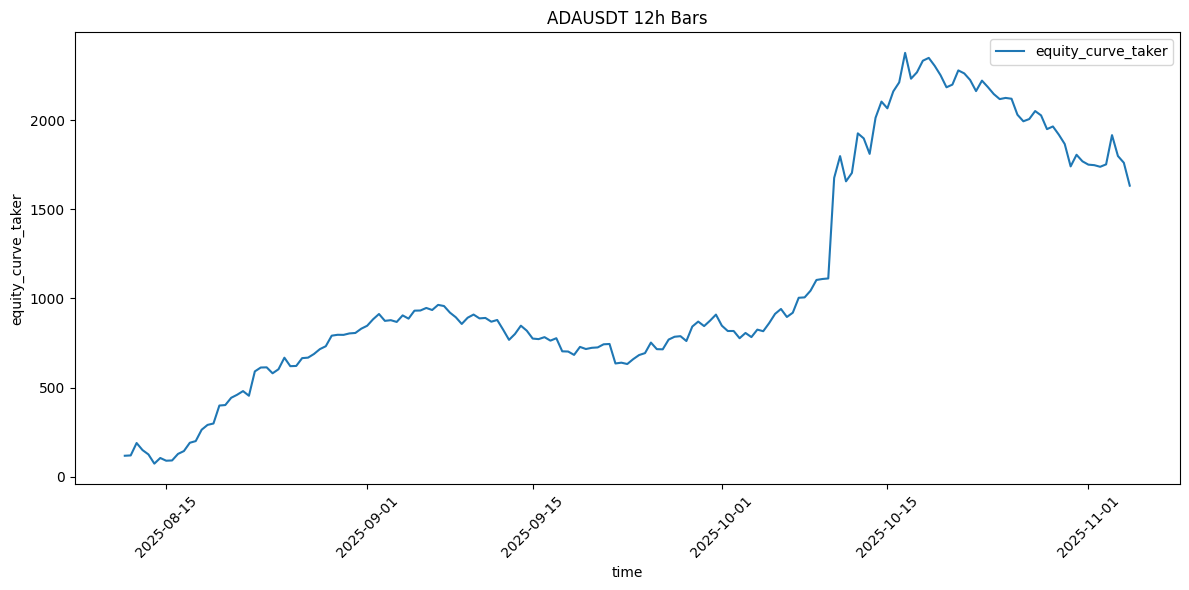

In [79]:
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)

In [80]:
trades = research.add_compounding_trades(trades, capital, leverage, maker_fee, taker_fee)
trades

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,y_hat,dir_signal,trade_log_return,cum_trade_log_return,entry_trade_value,exit_trade_value,trade_qty,signed_trade_qty,trade_gross_pnl,taker_fee,maker_fee,trade_net_taker_pnl,trade_net_maker_pnl,equity_curve_taker,equity_curve_maker,equity_curve_gross,tx_fee_maker,tx_fee_taker,liquidation_price,worst_price,liquidated
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool
2025-08-11 12:00:00,0.7902,0.8044,0.7656,0.7723,-0.022913,-0.0137,0.013826,-0.015572,-0.000168,-1.0,0.022913,0.022913,400.0,409.271009,126.55024,-506.200962,9.271009,0.091043,0.091043,8.906837,8.906837,108.906837,108.906837,109.271009,0.364172,0.364172,1.046623,0.8044,false
2025-08-12 00:00:00,0.7723,0.7884,0.765,0.7747,0.003103,-0.022913,-0.0137,0.013826,0.004183,1.0,0.003103,0.026016,409.271009,410.54286,129.483361,529.937859,1.271851,0.09014,0.09014,0.902935,0.902935,109.809771,109.809771,110.54286,0.368916,0.368916,0.620321,0.765,false
2025-08-12 12:00:00,0.7746,0.8581,0.7727,0.8411,0.082235,0.003103,-0.022913,-0.0137,0.001102,1.0,0.082235,0.10825,410.54286,445.730733,129.09889,530.006274,35.187874,0.093857,0.093857,34.802551,34.802551,144.612322,144.612322,145.730733,0.385323,0.385323,0.622169,0.7727,false
2025-08-13 00:00:00,0.841,0.8875,0.8333,0.8794,0.044529,0.082235,0.003103,-0.022913,-0.013993,-1.0,-0.044529,0.063721,445.730733,426.31808,118.906064,-530.000872,-19.412653,0.08804,0.08804,-19.805075,-19.805075,124.807247,124.807247,126.31808,0.392422,0.392422,1.113907,0.8875,false
2025-08-13 12:00:00,0.8794,0.9223,0.8615,0.9044,0.028032,0.044529,0.082235,0.003103,-0.016491,-1.0,-0.028032,0.035689,426.31808,414.533525,113.713896,-484.782898,-11.784556,0.088756,0.088756,-12.162939,-12.162939,112.644308,112.644308,114.533525,0.378383,0.378383,1.164768,0.9223,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.001239,-1.0,0.005881,1.229523,1359.818062,1367.839273,162.919518,-2215.409029,8.021211,0.090265,0.090265,6.793765,6.793765,926.023769,926.023769,1067.839273,1.227446,1.227446,0.81298,0.6141,false
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,-0.000182,-1.0,0.059059,1.288582,1367.839273,1451.055637,163.853842,-2241.257206,83.216365,0.092738,0.092738,81.947862,81.947862,1007.971631,1007.971631,1151.055637,1.268503,1.268503,0.808344,0.612,false
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.008993,1.0,-0.040257,1.248325,1451.055637,1393.800357,173.792145,2521.820712,-57.255281,0.088224,0.088224,-58.535466,-58.535466,949.436165,949.436165,1093.800357,1.280185,1.280185,0.462169,0.5244,false


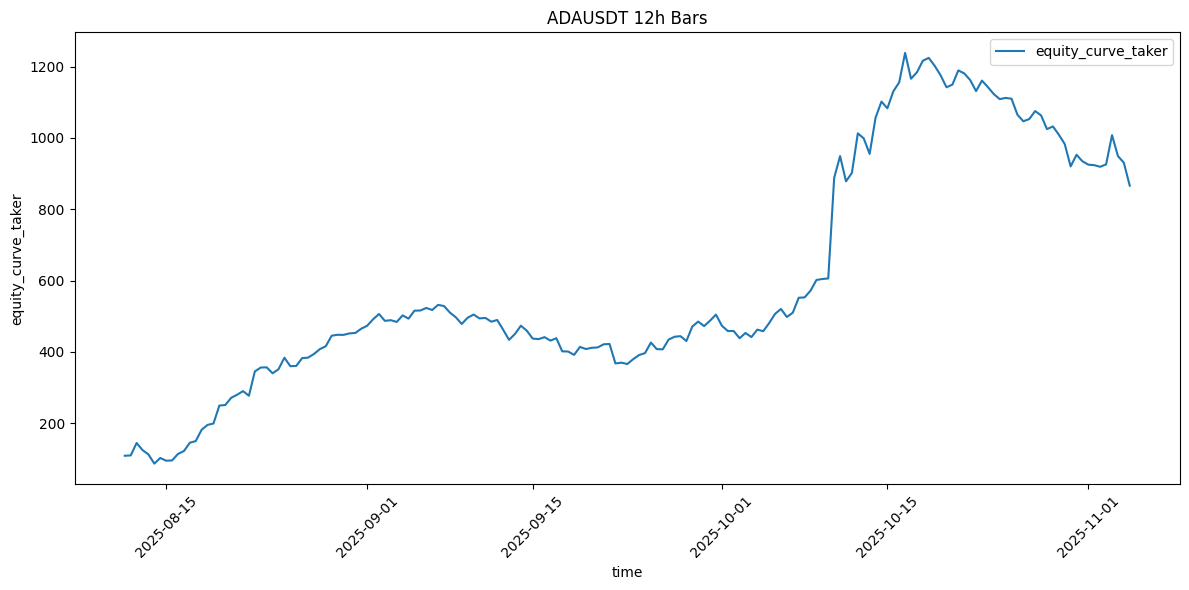

In [81]:
research.plot_static_timeseries(trades, sym, 'equity_curve_taker', time_interval)